In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.models import load_model
# from keras.metrics import sparse_top_k_categorical_accuracy
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold
from collections import Counter
import tensorflow.keras.backend as K
import numpy as np
import os
from tensorflow.keras.utils import to_categorical
import sys
import pandas as pd
import numpy as np
from PIL import Image
import io

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
import scipy
from scipy.stats import chi2_contingency
from mippiNetbuild import *
# sys.path.append('../input/mippi0801')
# from transformer import *
np.random.seed(0)

In [2]:
df_path = r'../data/skempi2_window_with_pssm.dataset'
df = pd.read_pickle(df_path)
pd.set_option('display.max_columns', None)
df.head()

,#Pdb,Mutation(s)_PDB,Mutation(s)_cleaned,iMutation_Location(s),Hold_out_type,Hold_out_proteins,Affinity_mut (M),Affinity_mut_parsed,Affinity_wt (M),Affinity_wt_parsed,Reference,Protein 1,Protein 2,Temperature,kon_mut (M^(-1)s^(-1)),kon_mut_parsed,kon_wt (M^(-1)s^(-1)),kon_wt_parsed,koff_mut (s^(-1)),koff_mut_parsed,koff_wt (s^(-1)),koff_wt_parsed,dH_mut (kcal mol^(-1)),dH_wt (kcal mol^(-1)),dS_mut (cal mol^(-1) K^(-1)),dS_wt (cal mol^(-1) K^(-1)),Notes,Method,SKEMPI version,ddg,PDB,chain1,chain2,refaa,mutaa,mutchain,pos0,pos1,mutchain_s,parchain_s,ori_seq,mut_seq,par_seq,pos1_w,ori_win,mut_win,mutAC,oriAC,parAC,pssm_par0,pssm_mut0_win,pssm_mut1_win
0,1CSE_E_I,LI45G,LI38G,COR,Pr/PI,Pr/PI,5.26E-11,5.260000e-11,1.12E-12,1.120000e-12,9048543,Subtilisin Carlsberg,Eglin c,294,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,IASP,1,2.248833,1CSE,E,I,[L],[G],[I],[45],[38],I,E,KSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLDLRYNRVR...,KSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTGDLRYNRVR...,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,38,QAREYFTLHYPQYNVYFLPEGSPVTLDLRYNRVRVFYNPGTNVVNH...,QAREYFTLHYPQYNVYFLPEGSPVTGDLRYNRVRVFYNPGTNVVNH...,1CSE_E_I_LI38G,1CSE_E_I_I,1CSE_E_I_E,"[[7.0, -7.0, -6.0, -7.0, -6.0, -6.0, -6.0, -5....","[[1.0, -2.0, -1.0, 1.0, -2.0, 1.0, 4.0, -3.0, ...","[[1.0, -2.0, -1.0, 2.0, -2.0, 1.0, 4.0, -3.0, ..."
1,1CSE_E_I,LI45S,LI38S,COR,Pr/PI,Pr/PI,8.33E-12,8.330000e-12,1.12E-12,1.120000e-12,9048543,Subtilisin Carlsberg,Eglin c,294,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,IASP,1,1.172229,1CSE,E,I,[L],[S],[I],[45],[38],I,E,KSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLDLRYNRVR...,KSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTSDLRYNRVR...,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,38,QAREYFTLHYPQYNVYFLPEGSPVTLDLRYNRVRVFYNPGTNVVNH...,QAREYFTLHYPQYNVYFLPEGSPVTSDLRYNRVRVFYNPGTNVVNH...,1CSE_E_I_LI38S,1CSE_E_I_I,1CSE_E_I_E,"[[7.0, -7.0, -6.0, -7.0, -6.0, -6.0, -6.0, -5....","[[1.0, -2.0, -1.0, 1.0, -2.0, 1.0, 4.0, -3.0, ...","[[1.0, -2.0, -1.0, 2.0, -2.0, 1.0, 4.0, -3.0, ..."
2,1CSE_E_I,LI45P,LI38P,COR,Pr/PI,Pr/PI,1.02E-07,1.020000e-07,1.12E-12,1.120000e-12,9048543,Subtilisin Carlsberg,Eglin c,294,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,IASP,1,6.671276,1CSE,E,I,[L],[P],[I],[45],[38],I,E,KSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLDLRYNRVR...,KSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTPDLRYNRVR...,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,38,QAREYFTLHYPQYNVYFLPEGSPVTLDLRYNRVRVFYNPGTNVVNH...,QAREYFTLHYPQYNVYFLPEGSPVTPDLRYNRVRVFYNPGTNVVNH...,1CSE_E_I_LI38P,1CSE_E_I_I,1CSE_E_I_E,"[[7.0, -7.0, -6.0, -7.0, -6.0, -6.0, -6.0, -5....","[[1.0, -2.0, -1.0, 1.0, -2.0, 1.0, 4.0, -3.0, ...","[[1.0, -2.0, -1.0, 1.0, -2.0, 1.0, 4.0, -3.0, ..."
3,1CSE_E_I,LI45I,LI38I,COR,Pr/PI,Pr/PI,1.72E-10,1.720000e-10,1.12E-12,1.120000e-12,9048543,Subtilisin Carlsberg,Eglin c,294,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,IASP,1,2.940988,1CSE,E,I,[L],[I],[I],[45],[38],I,E,KSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLDLRYNRVR...,KSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTIDLRYNRVR...,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,38,QAREYFTLHYPQYNVYFLPEGSPVTLDLRYNRVRVFYNPGTNVVNH...,QAREYFTLHYPQYNVYFLPEGSPVTIDLRYNRVRVFYNPGTNVVNH...,1CSE_E_I_LI38I,1CSE_E_I_I,1CSE_E_I_E,"[[7.0, -7.0, -6.0, -7.0, -6.0, -6.0, -6.0, -5....","[[1.0, -2.0, -1.0, 1.0, -2.0, 1.0, 4.0, -3.0, ...","[[1.0, -2.0, -1.0, 2.0, -2.0, 1.0, 4.0, -3.0, ..."
4,1CSE_E_I,LI45D,LI38D,COR,Pr/PI,Pr/PI,1.92E-09,1.920000e-09,1.12E-12,1.120000e-12,9048543,Subtilisin Carlsberg,Eglin c,294,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,IASP,1,4.350434,1CSE,E,I,[L],[D],[I],[45],[38],I,E,KSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLDLRYNRVR...,KSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTDDLRYNRVR...,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,38,QAREYFTLHYPQYNVYFLPEGSPVTLDLRYNRVRVFYNPGTNVVNH...,QAREYFTLHYPQYNVYFLPEGSPVTDDLRYNRVRVFYNPGTNVVNH...,1CSE_E_I_LI38D,1CSE_E_I_I,1CSE_E_I_E,"[[7.0, -7.0, -6.0, -7.0, -6.0, -6.0, -6.0, -5....","[[1.0, -2.0, -1.0, 1.0, -2.0, 1.0, 4.0, -3.0, ...","[[1.0, -2.0, 0.0, 2.0, -2.0,

In [3]:
aaDict = {'0':0, 'D':1, 'S':2, 'Q':3, 'K':4,
          'I':5, 'P':6, 'T':7, 'F':8, 'N':9,
          'G':10, 'H':11, 'L':12, 'R':13, 'W':14,
          'A':15, 'V':16, 'E':17, 'Y':18, 'M':19, 'C':20}
max_len = 1024
mut0_c = [[aaDict[x] for x in a] for a in df['ori_win']]
mut1_c = [[aaDict[x] for x in a] for a in df['mut_win']]
par0_c = [[aaDict[x] for x in a] for a in df['par_seq']]
# par1_c = [[aaDict[x] for x in a] for a in df['par0']]

window_len = 51
mut0_c = keras.preprocessing.sequence.pad_sequences(mut0_c, maxlen=window_len, padding='post')
mut1_c = keras.preprocessing.sequence.pad_sequences(mut1_c, maxlen=window_len, padding='post')
par0_c = keras.preprocessing.sequence.pad_sequences(par0_c, maxlen=max_len, padding='post')
# par1_c = keras.preprocessing.sequence.pad_sequences(par1_c, maxlen=window_len, padding='post')

# label = np.array(df['label'])
# # label = to_categorical(label, num_classes=5)
# # before change column: no_effect:0, disrupting:1, decreasing:2, increasing:3, causing:4
# # label = label[:, [1, 2, 0, 3, 4]]
# print(label.shape)

pssm_win_mut0 = df['pssm_mut0_win'].values
pssm_win_mut0 = np.stack(pssm_win_mut0, axis=0).astype('float32')
print(pssm_win_mut0.shape)

pssm_win_mut1 = df['pssm_mut1_win'].values
pssm_win_mut1 = np.stack(pssm_win_mut1, axis=0).astype('float32')
print(pssm_win_mut1.shape)

(2950, 51, 20)
(2950, 51, 20)


In [4]:
pssm_par0 = df['pssm_par0'].values
pssm_par0 = [x[:1024, :] for x in pssm_par0] # restrict par protein length to 1024
pssm_par0 = np.stack(pssm_par0, axis=0).astype('float32')
print(pssm_par0.shape)

(2950, 1024, 20)


In [5]:
data = [mut0_c, mut1_c, par0_c, pssm_win_mut0, pssm_win_mut1, pssm_par0]
data_reverse = [mut1_c, mut0_c, par0_c, pssm_win_mut1, pssm_win_mut0, pssm_par0]
data_no = [mut0_c, mut0_c, par0_c, pssm_win_mut0, pssm_win_mut0, pssm_par0]

In [7]:
K.clear_session()
model2 = build_model()
model2.summary()
adam = optimizers.Adam(learning_rate=0.0002)

# model_path = r'./pssm_in_trans/bestAcc.h53'
# model_path = r'/lustre/home/acct-bmelgn/bmelgn-2/QianWei/MIPPI2/src/kaggle/cross_validation/activation_test/s51_leaky_3block_wfl_gp_HE/bestAcc.h51'


# model_path = r'bestAcc.h54'
# model.load_weights(model_path)
model2.compile(adam, loss=categorical_focal_loss(alpha=[.25, .25, .1, .25], gamma=2.), 
              metrics=['acc', tf.keras.metrics.TopKCategoricalAccuracy(k=2, name='top2acc')])

score_arr = np.zeros((data[0].shape[0], 4))
score_reverse_arr = np.zeros((data[0].shape[0], 4))
class_arr = np.zeros((data[0].shape[0], 5))
class_reverse_arr = np.zeros((data[0].shape[0], 5))
for i in range(5):
    model_path = r'./via_att/s51_leaky_3block_wfl_gp_HE_no_re_cv5_best/bestAcc.h5' + str(i)
    model2.load_weights(model_path)
    pred = model2.predict(data)
    pred_reverse = model2.predict(data_reverse)
    pred_no = model2.predict(data_no)
    pred_class = pred.argmax(axis=-1)
    pred_reverse_class = pred_reverse.argmax(axis=-1)
    pred_no_class = pred_no.argmax(axis=-1)
    df['noda_pred_class' + str(i)] = pred_class
    df['noda_pred_reverse_class' + str(i)] = pred_reverse_class
    df['noda_pred_no_class' + str(i)] = pred_no_class
    score_arr += pred
    score_reverse_arr += pred_reverse
    
    class_arr[:, i] = pred_class
    class_reverse_arr[:, i] = pred_reverse_class

['cn/token_and_position_embedding/embedding/embeddings:0\n', 'cn/token_and_position_embedding_1/embedding_2/embeddings:0\n', 'cn/transformer_block/multi_head_self_attention/dense/kernel:0\n', 'cn/transformer_block/multi_head_self_attention/dense/bias:0\n', 'cn/transformer_block/multi_head_self_attention/dense_1/kernel:0\n', 'cn/transformer_block/multi_head_self_attention/dense_1/bias:0\n', 'cn/transformer_block/multi_head_self_attention/dense_2/kernel:0\n', 'cn/transformer_block/multi_head_self_attention/dense_2/bias:0\n', 'cn/transformer_block/multi_head_self_attention/dense_3/kernel:0\n', 'cn/transformer_block/multi_head_self_attention/dense_3/bias:0\n', 'dense_4/kernel:0\n', 'dense_4/bias:0\n', 'dense_5/kernel:0\n', 'dense_5/bias:0\n', 'cn/transformer_block/layer_normalization/gamma:0\n', 'cn/transformer_block/layer_normalization/beta:0\n', 'cn/transformer_block/layer_normalization_1/gamma:0\n', 'cn/transformer_block/layer_normalization_1/beta:0\n', 'cn/transformer_block_1/multi_hea

In [8]:
from collections import Counter
consistent_score = np.zeros(df.shape[0])
most_common = np.zeros(df.shape[0])
for i in range(class_arr.shape[0]):
    consistent_score[i] = Counter(class_arr[i]).most_common()[0][1]
    most_common[i] = Counter(class_arr[i]).most_common()[0][0]
df['noda_con_score'] = consistent_score
df['noda_most_common'] = most_common
score_cv5_class = score_arr.argmax(axis=-1)
score_cv5_reverse_class = score_reverse_arr.argmax(axis=-1)
df['noda_cv5_class'] = score_cv5_class
df['noda_cv5_reverse_class'] = score_cv5_reverse_class
df['noda_cv5_score'] = (score_arr / 5).max(axis=-1)
df['noda_cv5_reverse_score'] = (score_reverse_arr / 5).max(axis=-1)
df.head()

,#Pdb,Mutation(s)_PDB,Mutation(s)_cleaned,iMutation_Location(s),Hold_out_type,Hold_out_proteins,Affinity_mut (M),Affinity_mut_parsed,Affinity_wt (M),Affinity_wt_parsed,Reference,Protein 1,Protein 2,Temperature,kon_mut (M^(-1)s^(-1)),kon_mut_parsed,kon_wt (M^(-1)s^(-1)),kon_wt_parsed,koff_mut (s^(-1)),koff_mut_parsed,koff_wt (s^(-1)),koff_wt_parsed,dH_mut (kcal mol^(-1)),dH_wt (kcal mol^(-1)),dS_mut (cal mol^(-1) K^(-1)),dS_wt (cal mol^(-1) K^(-1)),Notes,Method,SKEMPI version,ddg,PDB,chain1,chain2,refaa,mutaa,mutchain,pos0,pos1,mutchain_s,parchain_s,ori_seq,mut_seq,par_seq,pos1_w,ori_win,mut_win,mutAC,oriAC,parAC,pssm_par0,pssm_mut0_win,pssm_mut1_win,noda_pred_class0,noda_pred_reverse_class0,noda_pred_no_class0,noda_pred_class1,noda_pred_reverse_class1,noda_pred_no_class1,noda_pred_class2,noda_pred_reverse_class2,noda_pred_no_class2,noda_pred_class3,noda_pred_reverse_class3,noda_pred_no_class3,noda_pred_class4,noda_pred_reverse_class4,noda_pred_no_class4,noda_con_score,noda_most_common,noda_cv5_class,noda_cv5_reverse_class,noda_cv5_score,noda_cv5_reverse_score
0,1CSE_E_I,LI45G,LI38G,COR,Pr/PI,Pr/PI,5.26E-11,5.260000e-11,1.12E-12,1.120000e-12,9048543,Subtilisin Carlsberg,Eglin c,294,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,IASP,1,2.248833,1CSE,E,I,[L],[G],[I],[45],[38],I,E,KSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLDLRYNRVR...,KSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTGDLRYNRVR...,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,38,QAREYFTLHYPQYNVYFLPEGSPVTLDLRYNRVRVFYNPGTNVVNH...,QAREYFTLHYPQYNVYFLPEGSPVTGDLRYNRVRVFYNPGTNVVNH...,1CSE_E_I_LI38G,1CSE_E_I_I,1CSE_E_I_E,"[[7.0, -7.0, -6.0, -7.0, -6.0, -6.0, -6.0, -5....","[[1.0, -2.0, -1.0, 1.0, -2.0, 1.0, 4.0, -3.0, ...","[[1.0, -2.0, -1.0, 2.0, -2.0, 1.0, 4.0, -3.0, ...",0,0,0,0,0,1,1,1,1,0,0,0,1,1,1,3.0,0.0,0,0,0.598146,0.598213
1,1CSE_E_I,LI45S,LI38S,COR,Pr/PI,Pr/PI,8.33E-12,8.330000e-12,1.12E-12,1.120000e-12,9048543,Subtilisin Carlsberg,Eglin c,294,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,IASP,1,1.172229,1CSE,E,I,[L],[S],[I],[45],[38],I,E,KSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLDLRYNRVR...,KSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTSDLRYNRVR...,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,38,QAREYFTLHYPQYNVYFLPEGSPVTLDLRYNRVRVFYNPGTNVVNH...,QAREYFTLHYPQYNVYFLPEGSPVTSDLRYNRVRVFYNPGTNVVNH...,1CSE_E_I_LI38S,1CSE_E_I_I,1CSE_E_I_E,"[[7.0, -7.0, -6.0, -7.0, -6.0, -6.0, -6.0, -5....","[[1.0, -2.0, -1.0, 1.0, -2.0, 1.0, 4.0, -3.0, ...","[[1.0, -2.0, -1.0, 2.0, -2.0, 1.0, 4.0, -3.0, ...",0,0,0,0,0,1,1,1,1,0,0,0,1,1,1,3.0,0.0,0,0,0.586340,0.593973
2,1CSE_E_I,LI45P,LI38P,COR,Pr/PI,Pr/PI,1.02E-07,1.020000e-07,1.12E-12,1.120000e-12,9048543,Subtilisin Carlsberg,Eglin c,294,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,IASP,1,6.671276,1CSE,E,I,[L],[P],[I],[45],[38],I,E,KSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLDLRYNRVR...,KSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTPDLRYNRVR...,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,38,QAREYFTLHYPQYNVYFLPEGSPVTLDLRYNRVRVFYNPGTNVVNH...,QAREYFTLHYPQYNVYFLPEGSPVTPDLRYNRVRVFYNPGTNVVNH...,1CSE_E_I_LI38P,1CSE_E_I_I,1CSE_E_I_E,"[[7.0, -7.0, -6.0, -7.0, -6.0, -6.0, -6.0, -5....","[[1.0, -2.0, -1.0, 1.0, -2.0, 1.0, 4.0, -3.0, ...","[[1.0, -2.0, -1.0, 1.0, -2.0, 1.0, 4.0, -3.0, ...",0,0,0,1,1,1,1,1,1,0,0,0,1,1,1,3.0,1.0,0,0,0.555025,0.550034
3,1CSE_E_I,LI45I,LI38I,COR,Pr/PI,Pr/PI,1.72E-10,1.720000e-10,1.12E-12,1.120000e-12,9048543,Subtilisin Carlsberg,Eglin c,294,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,IASP,1,2.940988,1CSE,E,I,[L],[I],[I],[45],[38],I,E,KSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLDLRYNRVR...,KSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTIDLRYNRVR...,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,38,QAREYFTLHYPQYNVYFLPEGSPVTLDLRYNRVRVFYNPGTNVVNH...,QAREYFTLHYPQYNVYFLPEGSPVTIDLRYNRVRVFYNPGTNVVNH...,1CSE_E_I_LI38I,1CSE_E_I_I,1CSE_E_I_E,"[[7.0, -7.0, -6.0, -7.0, -6.0, -6.0, -6.0, -5....","[[1.0, -2.0, -1.0, 1.0, -2.0, 1.0, 4.0, -3.0, ...","[[1.0, -2.0, -1.0, 2.0, -2.0, 1.0, 4.0, -3.0, ...",0,0,0,0,0,1,1,1,1,0,0,0,1,1,1,3.0,0.0,0,0,0.586403,0

In [32]:
noda_pred_results = pd.concat([df['ddg'], df['noda_cv5_class'], df['noda_cv5_reverse_class']],axis=1).reset_index(drop=True)
noda_pred_results.head()

,ddg,noda_cv5_class,noda_cv5_reverse_class
0,2.248833,0,0
1,1.172229,0,0
2,6.671276,0,0
3,2.940988,0,0
4,4.350434,0,0


In [168]:
plot_df = noda_pred_results.copy(deep=True)
noda_pred_results['ddg'].astype(float)
label_dict = {0: 'disrupting', 1: 'decreasing', 2: 'no effect', 3:'increasing'}
for i in range(noda_pred_results.shape[0]):
    if(noda_pred_results['ddg'][i] > -1):
        plot_df['ddg'][i] = 'decreasing'
    elif(noda_pred_results['ddg'][i] <= -1):
        plot_df['ddg'][i] = 'increasing'
    else:
        plot_df['ddg'][i] = 'no effect'
    plot_df['noda_cv5_class'][i] = label_dict[noda_pred_results['noda_cv5_class'][i]]
    plot_df['noda_cv5_reverse_class'][i] = label_dict[noda_pred_results['noda_cv5_reverse_class'][i]]
plot_df.head()

C:\Users\Administrator\AppData\Local\Temp\ipykernel_12940\429295193.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['ddg'][i] = 'decreasing'
C:\Users\Administrator\AppData\Local\Temp\ipykernel_12940\429295193.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['noda_cv5_class'][i] = label_dict[noda_pred_results['noda_cv5_class'][i]]
C:\Users\Administrator\AppData\Local\Temp\ipykernel_12940\429295193.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

,ddg,noda_cv5_class,noda_cv5_reverse_class
0,decreasing,disrupting,disrupting
1,decreasing,disrupting,disrupting
2,decreasing,disrupting,disrupting
3,decreasing,disrupting,disrupting
4,decreasing,disrupting,disrupting


In [169]:
plot_df2 = pd.read_csv("da_pred_results.csv")
plot_df2.head()

,Unnamed: 0,ddg,cv5_class,cv5_reverse_class
0,0,decreasing,disrupting,disrupting
1,1,decreasing,disrupting,disrupting
2,2,decreasing,disrupting,disrupting
3,3,decreasing,disrupting,disrupting
4,4,decreasing,disrupting,increasing


In [170]:
ddg_df = pd.concat([plot_df['ddg'], plot_df2['cv5_class'], plot_df2['cv5_reverse_class'], plot_df['noda_cv5_class'], plot_df['noda_cv5_reverse_class']],axis=1).reset_index(drop=True)
#ddg_df[['cv5_class', 'cv5_reverse_class', 'noda_cv5_class', 'noda_cv5_reverse_class']] = ddg_df[['cv5_class', 'cv5_reverse_class', 'noda_cv5_class', 'noda_cv5_reverse_class']].astype(int)
print(ddg_df.shape)
ddg_df.head()

(2950, 5)


,ddg,cv5_class,cv5_reverse_class,noda_cv5_class,noda_cv5_reverse_class
0,decreasing,disrupting,disrupting,disrupting,disrupting
1,decreasing,disrupting,disrupting,disrupting,disrupting
2,decreasing,disrupting,disrupting,disrupting,disrupting
3,decreasing,disrupting,disrupting,disrupting,disrupting
4,decreasing,disrupting,increasing,disrupting,disrupting


In [171]:
plot_df = ddg_df
plot_df.head()

,ddg,cv5_class,cv5_reverse_class,noda_cv5_class,noda_cv5_reverse_class
0,decreasing,disrupting,disrupting,disrupting,disrupting
1,decreasing,disrupting,disrupting,disrupting,disrupting
2,decreasing,disrupting,disrupting,disrupting,disrupting
3,decreasing,disrupting,disrupting,disrupting,disrupting
4,decreasing,disrupting,increasing,disrupting,disrupting


In [172]:
decreasing_df = plot_df[plot_df['ddg'] == "decreasing"]
noeffect_df = plot_df[plot_df['ddg'] == "no effect"]
increasing_df = plot_df[plot_df['ddg'] == "increasing"]
print(decreasing_df.shape)
print(noeffect_df.shape)
print(increasing_df.shape)

(2797, 5)
(0, 5)
(153, 5)


In [173]:
print(decreasing_df.groupby('cv5_class').count()['ddg'])
print(decreasing_df.groupby('cv5_reverse_class').count()['ddg'])
print(decreasing_df.groupby('noda_cv5_class').count()['ddg'])
print(decreasing_df.groupby('noda_cv5_reverse_class').count()['ddg'])

cv5_class
decreasing     643
disrupting    1411
increasing      79
no effect      664
Name: ddg, dtype: int64
cv5_reverse_class
decreasing      74
disrupting     333
increasing    1519
no effect      871
Name: ddg, dtype: int64
noda_cv5_class
decreasing    1116
disrupting    1459
increasing      10
no effect      212
Name: ddg, dtype: int64
noda_cv5_reverse_class
decreasing     904
disrupting    1568
increasing      10
no effect      315
Name: ddg, dtype: int64


In [174]:
print(noeffect_df.groupby('cv5_class').count()['ddg'])
print(noeffect_df.groupby('cv5_reverse_class').count()['ddg'])
print(noeffect_df.groupby('noda_cv5_class').count()['ddg'])
print(noeffect_df.groupby('noda_cv5_reverse_class').count()['ddg'])

Series([], Name: ddg, dtype: int64)
Series([], Name: ddg, dtype: int64)
Series([], Name: ddg, dtype: int64)
Series([], Name: ddg, dtype: int64)


In [175]:
print(increasing_df.groupby('cv5_class').count()['ddg'])
print(increasing_df.groupby('cv5_reverse_class').count()['ddg'])
print(increasing_df.groupby('noda_cv5_class').count()['ddg'])
print(increasing_df.groupby('noda_cv5_reverse_class').count()['ddg'])
increasing_plot_df = pd.concat([increasing_df.groupby('cv5_class').count()['ddg'], increasing_df.groupby('cv5_reverse_class').count()['ddg'], increasing_df.groupby('noda_cv5_class').count()['ddg'], increasing_df.groupby('noda_cv5_reverse_class').count()['ddg']],axis=1).reset_index(drop=True)
increasing_plot_df.columns=['cv5_class','cv5_reverse_class','noda_cv5_class','noda_cv5_reverse_class']
increasing_plot_df.index=['decreasing','disrupting','increasing','no effect']
increasing_plot_df=increasing_plot_df.reindex(['decreasing','disrupting','no effect','increasing'])
increasing_plot_df

cv5_class
decreasing     9
disrupting    22
increasing    52
no effect     70
Name: ddg, dtype: int64
cv5_reverse_class
decreasing    31
disrupting    44
increasing    16
no effect     62
Name: ddg, dtype: int64
noda_cv5_class
decreasing    32
disrupting    98
increasing     3
no effect     20
Name: ddg, dtype: int64
noda_cv5_reverse_class
decreasing    40
disrupting    89
increasing     3
no effect     21
Name: ddg, dtype: int64


,cv5_class,cv5_reverse_class,noda_cv5_class,noda_cv5_reverse_class
decreasing,9,31,32,40
disrupting,22,44,98,89
no effect,70,62,20,21
increasing,52,16,3,3


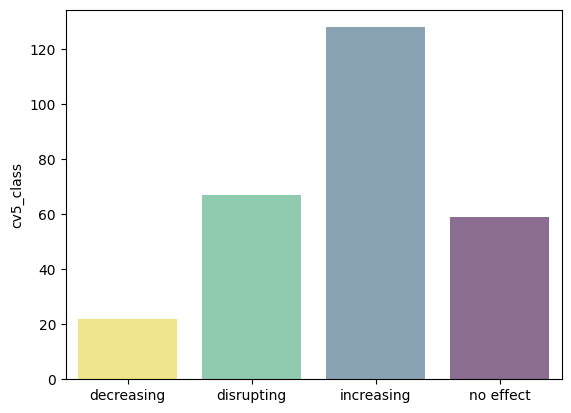

In [78]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
ax = sns.barplot(x=['decreasing','disrupting','increasing','no effect'], y=increasing_plot_df['cv5_class'], palette=['#FFF17C', '#86D4AF', '#83A4BB', '#8F6798'])